In [ ]:
# # TO DO list
# DONE: removing period from the training set '.' --> no need to learn it
# DONE: training over 20 epochs --> best accuracy was obtained in epoch 6 or 7
# BACKLOG: changing dataset to abstract-citation set
# BACKLOG: trainnig our own tokenizer
# BACKLOG: hyperparameter tuning (learning rate & batch size & masking prob in DataCollatorForLanguageModeling())
# BACKLOG: increasing the dataset size

# Training BERT Base for Arbitrary 5W Facts from Scratch

In [1]:
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import AdamW
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForMaskedLM, DataCollatorForLanguageModeling

2024-05-10 15:07:05.301707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 15:07:05.301854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 15:07:05.421568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = pd.read_csv('/kaggle/input/dl2-5w-dataset/5W_dataset.csv') 
data['sentences'] = data['sentences'].apply(lambda x: x.replace('.', '')) # removing '.' 
print(data.shape)

(20000, 5)


# Tokenizer

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# from tokenizers import Tokenizer
# from tokenizers.models import BPE
# from tokenizers.trainers import BpeTrainer
# from tokenizers.pre_tokenizers import Whitespace
# 
# tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
# tokenizer.pre_tokenizer = Whitespace()
# trainer = BpeTrainer(special_tokens=["[UNK]", "[PAD]", "[MASK]", "[CLS]", "[SEP]"])
# tokenizer.train_from_iterator(data['sentences'].to_list(), trainer)
# 
# tokenizer.save('tokenizer.json')
# del tokenizer
# tokenizer = BertTokenizer.from_pretrained('/kaggle/working/tokenizer.json')

# Dataset & Model Setup

In [4]:
N_EPOCH = 20
BATCH_SIZE = 16
WEIGHT_DECAY = 0.01
LEARNING_RATE = 3e-5
MODEL_NAME = 'bert_model_3'

config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=64,
    type_vocab_size=1,
    initializer_range=0.02
)

In [5]:
class BertDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=64):
        self.padding = 'max_length'
        self.data = df['sentences'].to_list()
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.encodings = self.tokenizer(self.data, padding=self.padding, truncation=True, 
                                        max_length=self.max_length, return_tensors='pt')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = item['input_ids'].detach().clone()
        return item

def model_predict(sentence_list, printer=False, top_k=5):
    n_correct = 0
    n_correct_top_k = 0
    true_labels = []
    eval_tokenized = tokenizer(sentence_list, padding='longest', truncation=True, return_tensors='pt')
    
    # randomly masking tokens in each sentence
    for i in range(eval_tokenized['input_ids'].shape[0]):
        n_tokens = sum(eval_tokenized['attention_mask'][i])
        random_mask_idx = random.randint(1,n_tokens-2) # eliminating start & end tokens 
        true_token = eval_tokenized['input_ids'][i, random_mask_idx].item()
        true_labels += [true_token]
        eval_tokenized['input_ids'][i, random_mask_idx] = tokenizer.mask_token_id

    model.eval()
    with torch.no_grad():
        eval_outputs = model(**eval_tokenized.to(device))
    
    eval_logits = eval_outputs['logits']
    for i in range(len(sentence_list)):
        mask_idx = torch.where(eval_tokenized['input_ids'][i]==tokenizer.mask_token_id)[0].item()
        eval_probs = torch.topk(F.softmax(eval_logits[i, mask_idx, :],dim=0), top_k).values    
        eval_preds = torch.topk(eval_logits[i, mask_idx, :], top_k).indices
        eval_preds_tokens = tokenizer.convert_ids_to_tokens(eval_preds)
        if(eval_preds[0].item()==true_labels[i]):
            n_correct += 1
        if(true_labels[i] in eval_preds.tolist()):
            n_correct_top_k += 1
        if(printer):
            print(f"[{i}] SENTENCE.........:", sentence_list[i])
            print(f"[{i}] MASKED TOKEN.....:", tokenizer.convert_ids_to_tokens(true_labels[i]))
            print(f"[{i}] TOP {top_k} MODEL PREDS:", eval_preds_tokens)
            print(f"[{i}] CONFIDENCE:......:", [round(x, 2) for x in eval_probs.tolist()], '\n')
    print('ACCURACY.............:', round(n_correct/len(sentence_list),2))
    print(f"ACCURACY TOP {top_k}.......:", round(n_correct_top_k/len(sentence_list),2))
    return (n_correct/len(sentence_list), round(n_correct_top_k/len(sentence_list),2))

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

dataset = BertDataset(data, tokenizer)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.2)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=data_collator)

model = BertForMaskedLM(config=config).to(device) # BERT()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
print('model n_parameters:', model.num_parameters())

cuda
model n_parameters: 109169466


# Model Training

In [7]:
val_set = data['sentences'].head(2000).to_list()
training_loss = []
training_acc = []
training_acc_k = []
lowest_loss = 999

model.train()
for epoch in range(N_EPOCH):
    total_loss = 0.0
    for step, batch in enumerate(tqdm(data_loader)):
        model.zero_grad()
        outputs = model(**batch.to(device))
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"epoch [{epoch+1}/{N_EPOCH}] avg loss: {total_loss/len(data_loader):.4f}")
    training_loss += [total_loss/len(data_loader)]
    acc_1, acc_2 = model_predict(val_set, top_k=3)
    training_acc += [acc_1]
    training_acc_k += [acc_2]
    if ((total_loss/len(data_loader))<lowest_loss):
        torch.save(model.state_dict(), f"{MODEL_NAME}.pth")
        lowest_loss = total_loss/len(data_loader)
        print(f"> > model is saved at epoch {epoch+1} with the loss of {round(lowest_loss,4)}.")

100%|██████████| 1250/1250 [03:03<00:00,  6.80it/s]


epoch [1/20] avg loss: 2.4646
ACCURACY.............: 0.64
ACCURACY TOP 3.......: 0.72
> > model is saved at epoch 1 with the loss of 2.464626618862152.


100%|██████████| 1250/1250 [03:02<00:00,  6.87it/s]


epoch [2/20] avg loss: 1.1320
ACCURACY.............: 0.65
ACCURACY TOP 3.......: 0.74
> > model is saved at epoch 2 with the loss of 1.1320146899223327.


100%|██████████| 1250/1250 [03:01<00:00,  6.87it/s]


epoch [3/20] avg loss: 1.0705
ACCURACY.............: 0.65
ACCURACY TOP 3.......: 0.74
> > model is saved at epoch 3 with the loss of 1.0704689368724822.


100%|██████████| 1250/1250 [03:01<00:00,  6.87it/s]


epoch [4/20] avg loss: 1.0576
ACCURACY.............: 0.65
ACCURACY TOP 3.......: 0.73
> > model is saved at epoch 4 with the loss of 1.0575695098280906.


100%|██████████| 1250/1250 [03:01<00:00,  6.87it/s]


epoch [5/20] avg loss: 1.0503
ACCURACY.............: 0.64
ACCURACY TOP 3.......: 0.73
> > model is saved at epoch 5 with the loss of 1.0503037584304808.


100%|██████████| 1250/1250 [03:01<00:00,  6.87it/s]


epoch [6/20] avg loss: 1.0376
ACCURACY.............: 0.64
ACCURACY TOP 3.......: 0.72
> > model is saved at epoch 6 with the loss of 1.0375575404644013.


100%|██████████| 1250/1250 [03:01<00:00,  6.88it/s]


epoch [7/20] avg loss: 1.0370
ACCURACY.............: 0.63
ACCURACY TOP 3.......: 0.72
> > model is saved at epoch 7 with the loss of 1.0370342625200748.


100%|██████████| 1250/1250 [03:01<00:00,  6.88it/s]


epoch [8/20] avg loss: 1.0410
ACCURACY.............: 0.64
ACCURACY TOP 3.......: 0.73


100%|██████████| 1250/1250 [03:01<00:00,  6.88it/s]


epoch [9/20] avg loss: 1.0390
ACCURACY.............: 0.65
ACCURACY TOP 3.......: 0.74


100%|██████████| 1250/1250 [03:01<00:00,  6.88it/s]


epoch [10/20] avg loss: 1.0322
ACCURACY.............: 0.64
ACCURACY TOP 3.......: 0.72
> > model is saved at epoch 10 with the loss of 1.032159053826332.


100%|██████████| 1250/1250 [03:01<00:00,  6.89it/s]


epoch [11/20] avg loss: 1.0385
ACCURACY.............: 0.66
ACCURACY TOP 3.......: 0.74


100%|██████████| 1250/1250 [03:01<00:00,  6.88it/s]


epoch [12/20] avg loss: 1.0315
ACCURACY.............: 0.63
ACCURACY TOP 3.......: 0.73
> > model is saved at epoch 12 with the loss of 1.0315006812870502.


100%|██████████| 1250/1250 [03:01<00:00,  6.88it/s]


epoch [13/20] avg loss: 1.0290
ACCURACY.............: 0.65
ACCURACY TOP 3.......: 0.73
> > model is saved at epoch 13 with the loss of 1.029000274848938.


100%|██████████| 1250/1250 [03:01<00:00,  6.88it/s]


epoch [14/20] avg loss: 1.0293
ACCURACY.............: 0.64
ACCURACY TOP 3.......: 0.73


100%|██████████| 1250/1250 [03:01<00:00,  6.88it/s]


epoch [15/20] avg loss: 1.0339
ACCURACY.............: 0.64
ACCURACY TOP 3.......: 0.73


100%|██████████| 1250/1250 [03:01<00:00,  6.88it/s]


epoch [16/20] avg loss: 1.0353
ACCURACY.............: 0.65
ACCURACY TOP 3.......: 0.74


100%|██████████| 1250/1250 [03:01<00:00,  6.88it/s]


epoch [17/20] avg loss: 1.0209
ACCURACY.............: 0.65
ACCURACY TOP 3.......: 0.74
> > model is saved at epoch 17 with the loss of 1.020877880859375.


100%|██████████| 1250/1250 [03:01<00:00,  6.88it/s]


epoch [18/20] avg loss: 1.0230
ACCURACY.............: 0.65
ACCURACY TOP 3.......: 0.73


100%|██████████| 1250/1250 [03:01<00:00,  6.88it/s]


epoch [19/20] avg loss: 1.0156
ACCURACY.............: 0.65
ACCURACY TOP 3.......: 0.75
> > model is saved at epoch 19 with the loss of 1.015553526544571.


100%|██████████| 1250/1250 [03:01<00:00,  6.88it/s]


epoch [20/20] avg loss: 1.0325
ACCURACY.............: 0.65
ACCURACY TOP 3.......: 0.74


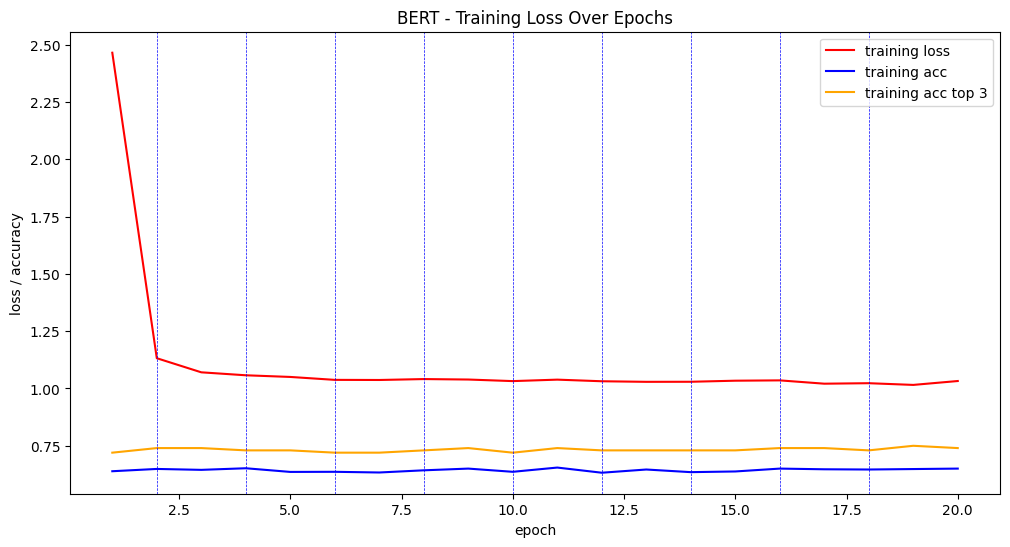

In [11]:
x_axis = list(range(1, 21))
plt.figure(figsize=(12, 6))
plt.plot(x_axis, training_loss, color='r', label='training loss')
plt.plot(x_axis, training_acc, color='b', label='training acc')
plt.plot(x_axis, training_acc_k, color='orange', label='training acc top 3')
[plt.axvline(x=_x, ls='--', lw=0.5, c='b') for _x in range(2,20,2)]
plt.title('BERT - Training Loss Over Epochs')
plt.xlabel('epoch')
plt.ylabel('loss / accuracy')
plt.legend(loc='upper right')
plt.savefig(f"{MODEL_NAME}.png", bbox_inches='tight')
plt.show();

# Model Evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=64,
    type_vocab_size=1,
    initializer_range=0.02
)

model = BertForMaskedLM(config=config).to(device)
model.load_state_dict(torch.load('/kaggle/input/dl2-5w-model/bert_model_1.pth'))

In [10]:
eval_set = data['sentences'].sample(20).to_list()
model_predict(eval_set, top_k=5, printer=True)

[0] SENTENCE.........: Rachel ate steak last Thursday in the park
[0] MASKED TOKEN.....: last
[0] TOP 5 MODEL PREDS: ['last', 'this', 'weekend', '##cos', '##ag']
[0] CONFIDENCE:......: [1.0, 0.0, 0.0, 0.0, 0.0] 

[1] SENTENCE.........: Emily ate lasagna one hour ago in the garden
[1] MASKED TOKEN.....: one
[1] TOP 5 MODEL PREDS: ['one', 'two', '##ag', '##tte', 'weekend']
[1] CONFIDENCE:......: [0.96, 0.04, 0.0, 0.0, 0.0] 

[2] SENTENCE.........: Robert ate lasagna last Tuesday in the garden
[2] MASKED TOKEN.....: last
[2] TOP 5 MODEL PREDS: ['last', 'this', 'recently', 'afternoon', 'weekend']
[2] CONFIDENCE:......: [1.0, 0.0, 0.0, 0.0, 0.0] 

[3] SENTENCE.........: Lucas ate omelette last winter in the park
[3] MASKED TOKEN.....: ##ele
[3] TOP 5 MODEL PREDS: ['##ele', '##ag', '##la', 'rooftop', '##so']
[3] CONFIDENCE:......: [1.0, 0.0, 0.0, 0.0, 0.0] 

[4] SENTENCE.........: Emma ate falafel last Tuesday at the mall
[4] MASKED TOKEN.....: emma
[4] TOP 5 MODEL PREDS: ['hannah', 'jason',

(0.7, 0.85)